In [111]:
# Load from pkl files
import pandas as pd
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import time
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


with open('./Input/8-mers/mic_dframe.pkl', 'rb') as file:
    mic_dframe = pickle.load(file)
with open('./Input/8-mers/suscep_classes.pkl', 'rb') as file:
    suscep_classes = pd.read_pickle(file)
    

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

antibiotics = mic_dframe.columns[-12:]

def prob_to_onehot(y):
    for i in range(0, y.shape[0]):
        greater = 0
        pos = 0
        for j in range(0, y.shape[1]):
            if y[i][j] >= greater:
                greater = y[i][j]
                pos = j
            y[i][j] = 0.0
        y[i][pos] = 1.0
    return y

def best_N_features(target_df, antibiotic, N):
    path = './input/8-mers/counts/'
    genome_ids = target_df['Genome ID'].loc[pd.notnull(target_df[antibiotic])].values
    X = np.array([np.load(path + genome_id + '.npy') for genome_id in genome_ids])
    y = target_df[antibiotic].loc[pd.notnull(target_df[antibiotic])].values
    n_best = SelectKBest(chi2, k=N)
    X_new = n_best.fit_transform(X, y*10**5)
    kmers = np.load('./input/8-mers/kmers_basis.npy')
    selected_kmers = [column[0]  for column in zip(kmers, n_best.get_support()) if column[1]]
    #scores = k_best.fit(X,y).scores_
    best_feature_df = pd.DataFrame(X_new, columns = selected_kmers)
    return best_feature_df

def class_weighting(df, antibiotic, cv):
    # Unique mic values
    mics = df[antibiotic].loc[pd.notnull(df[antibiotic])].unique()
    # Samples per class
    samples = {mic : len(df.loc[df[antibiotic]==mic]) for mic in mics}
    # Sorted classes
    mics = sorted([key for key in samples.keys()])
    # total data
    total = len(df.loc[pd.notnull(df[antibiotic])])
    # class weights
    class_weight = {i: (1 / samples[mic])*(total/len(mics))*(1/cv) for i, mic in enumerate(mics)}
    
    return class_weight

models = {}

**Ampicillin**


In [112]:

antibiotic = 'ampicillin'

kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic=antibiotic, N=2000)

# Features
X = kmer_dframe.values

# Standardize the input data
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Target
# list of MIC values
y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values

# reshape the list of mics
y_reshape = np.reshape(y,(-1,1))

# define encoder function
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# transform the target categorical data to onehot code
y_onehot = encoder.fit_transform(y_reshape)

# Split into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=0)

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Time: 21.61 seconds
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
Test set accuracy: 0.8308823529411765
Best Validation Loss: 0.93
Best Validation Accuracy: 0.81
Best Train Loss: 0.29
Best Train Accuracy: 0.97


Text(0.5, 25.722222222222214, 'Predicted label')

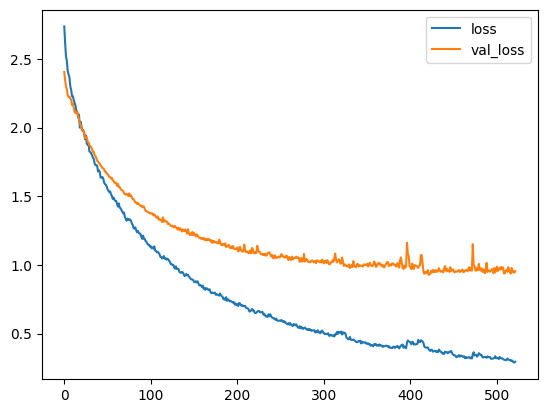

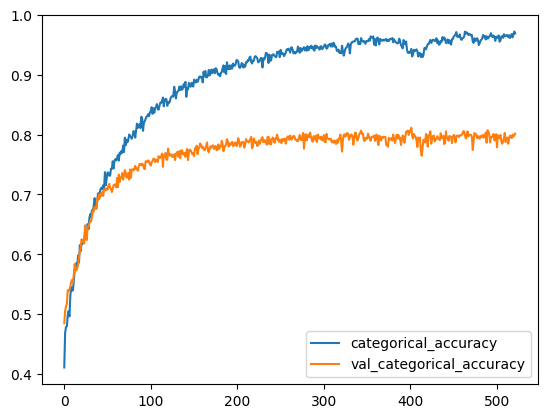

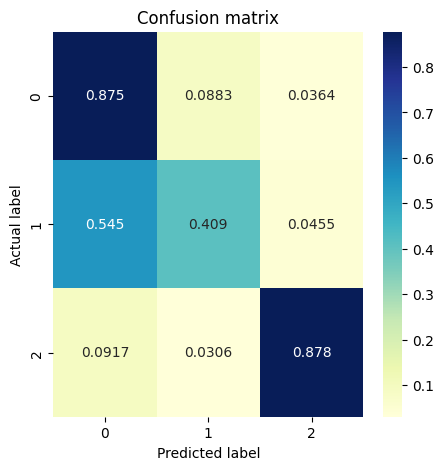

In [113]:

# Model building function
def make_model_ampicillin(loss='categorical_crossentropy', metrics=['categorical_accuracy']):
    
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.HeNormal()
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, decay_steps=10000, decay_rate=0.99, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                    use_bias=False, input_shape=[X.shape[1]]))
    model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,
                                                center=True, scale=True, 
                                                beta_initializer='zeros', 
                                                gamma_initializer='ones', 
                                                moving_mean_initializer='zeros', 
                                                moving_variance_initializer='ones'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax'))
    

    # Add the cross-entropy loss and accuracy metric for threshold probability
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    return model

# Include an early stopping callback for convenience
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor (loss or val_loss)
    monitor='val_loss',
    # how many epochs to wait before stopping (minimum epochs)
    patience=100,
    # minimium amount of change to count as an improvement
    min_delta=0.001,
    restore_best_weights=True,
)


starttime = time.time()

class_weight = class_weighting(mic_dframe, antibiotic, cv=1)
# Define the model
model = make_model_ampicillin()
models.update({antibiotic:model})

history = model.fit(
    X_train, y_train,
    shuffle=True,
    validation_split=0.3,
    #validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    class_weight = class_weight,
    verbose=0, # hide the output because we have so many epochs
)

print('Training Time: {:0.2f} seconds'.format(time.time() - starttime))

y_pred = model.predict(X_test)
y_pred = prob_to_onehot(y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Test set accuracy: " + str(accuracy))


# Plot the loss (accuracy) and validation loss (accuracy) functions-----------------------------------------------------

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.2f}" + "\nBest Validation Accuracy: {:0.2f}" + "\nBest Train Loss: {:0.2f}" + 
       "\nBest Train Accuracy: {:0.2f}")\
      .format(history_df['val_loss'].min(), history_df['val_categorical_accuracy'].max(), history_df["loss"].min(), 
              history_df["categorical_accuracy"].max()))



# Make predictions and decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]
# True mic values in string format
mics_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
# Unique mic values
mics = [str(mic) for mic in sorted(mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].unique())]
# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


**amoxicillin/clavulanic acid**

In [116]:
antibiotic = 'amoxicillin/clavulanic acid'

kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic=antibiotic, N=2000)

# Features
X = kmer_dframe.values

# Standardize the input data
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Target
# list of MIC values
y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values

# reshape the list of mics
y_reshape = np.reshape(y,(-1,1))

# define encoder function
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# transform the target categorical data to onehot code
y_onehot = encoder.fit_transform(y_reshape)

# Split into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=0)

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Time: 37.60 seconds
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test set accuracy: 0.8524844720496895
Best Validation Loss: 0.79
Best Validation Accuracy: 0.84
Best Train Loss: 0.28
Best Train Accuracy: 0.93


Text(0.5, 25.722222222222214, 'Predicted label')

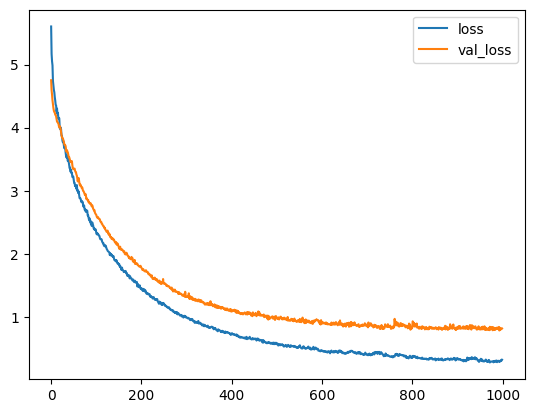

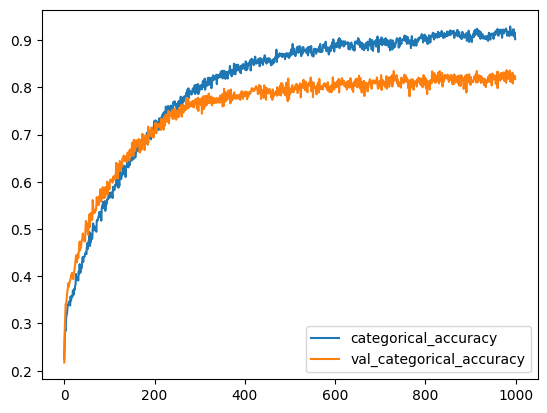

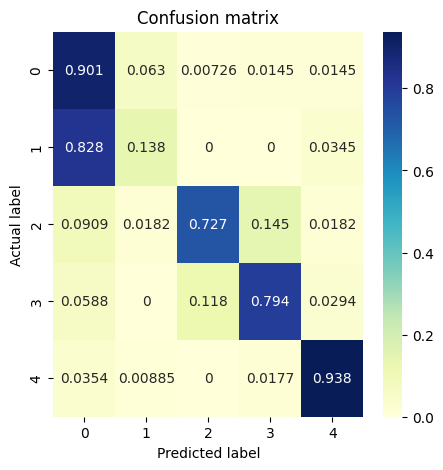

In [125]:
# Model building function
def make_model_amoxicillin(loss='categorical_crossentropy', metrics=['categorical_accuracy']):
    
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.HeNormal()
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, decay_steps=10000, decay_rate=0.99, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.02),
                                    use_bias=False, input_shape=[X.shape[1]]))
    model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001,
                                                center=True, scale=True, 
                                                beta_initializer='zeros', 
                                                gamma_initializer='ones', 
                                                moving_mean_initializer='zeros', 
                                                moving_variance_initializer='ones'))
    model.add(tf.keras.layers.Dropout(0.7))
    model.add(tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax'))
    

    # Add the cross-entropy loss and accuracy metric for threshold probability
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    return model

# Include an early stopping callback for convenience
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor (loss or val_loss)
    monitor='val_loss',
    # how many epochs to wait before stopping (minimum epochs)
    patience=500,
    # minimium amount of change to count as an improvement
    min_delta=0.001,
    restore_best_weights=True,
)


starttime = time.time()

class_weight = class_weighting(mic_dframe, antibiotic, cv=1)
# Define the model
model = make_model_amoxicillin()
models.update({antibiotic:model})

history = model.fit(
    X_train, y_train,
    shuffle=True,
    validation_split=0.3,
    #validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    class_weight = class_weight,
    verbose=0, # hide the output because we have so many epochs
)

print('Training Time: {:0.2f} seconds'.format(time.time() - starttime))

y_pred = model.predict(X_test)
y_pred = prob_to_onehot(y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Test set accuracy: " + str(accuracy))


# Plot the loss (accuracy) and validation loss (accuracy) functions-----------------------------------------------------

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.2f}" + "\nBest Validation Accuracy: {:0.2f}" + "\nBest Train Loss: {:0.2f}" + 
       "\nBest Train Accuracy: {:0.2f}")\
      .format(history_df['val_loss'].min(), history_df['val_categorical_accuracy'].max(), history_df["loss"].min(), 
              history_df["categorical_accuracy"].max()))



# Make predictions and decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]
# True mic values in string format
mics_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
# Unique mic values
mics = [str(mic) for mic in sorted(mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].unique())]
# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')